**Tutorial 4: Train SimSiam on Satellite Images**

https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html

***

***

# Try: balanced dataset

https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/

## Imports

In [1]:
import torch
import torchvision

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead,SimSiamProjectionHead

import matplotlib.pyplot as plt
import numpy as np
import math

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [6]:
# Hyperparamenters.
input_size = 224  # input_size = 256
batch_size = 32   # batch_size = 128
num_workers = 8
epochs = 3

# Dimension of the embeddings.
num_ftrs = 512
# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512
# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

# Seed torch and numpy.
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

# Dataset path.
data_dir = 'datasets/Sentinel2GlobalLULC_raw/Sentinel2LULC_JPEG/'

## Dataset

### ImageFolder

In [7]:
# Torchvision custom transforms.
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size, scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    #torchvision.transforms.ToTensor(),
])

# Create the dataset using ImageFolder.
# dataset = torchvision.datasets.ImageFolder(root=data_dir,
#                                            transform=transform)
dataset = torchvision.datasets.ImageFolder(root=data_dir)

In [8]:
print('Full dataset: ' + str(len(dataset.targets)))

Full dataset: 194877


In [9]:
print('Classes and samples per class: ' + str(np.unique(dataset.targets, return_counts=True)))

Classes and samples per class: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([14000,  4656,  8869, 14000, 11937,  4437,  1348, 14000, 10438,
        6380,  2880,   567,  1258, 14000,  3914,  3872, 13991,   416,
         487,  4205, 14000, 14000, 14000,  2004,   842,  1020,   353,
         413, 12590]))


### Train-val split

In [ ]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(
    #     mean=lightly.data.collate.imagenet_normalize['mean'],
    #     std=lightly.data.collate.imagenet_normalize['std'],
    # )
])

In [ ]:
# Size of the dataset.
dataset_size = dataset.__len__()

# Train and validation samples.
train_count = int(dataset_size * 0.7)
val_count = dataset_size - train_count
print('Train samples: ' + str(train_count))
print('Valid samples: ' + str(val_count))

# Random split.
train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                           [train_count, val_count])

dataset_train_simsiam = lightly.data.LightlyDataset.from_torch_dataset(train_dataset,
                                                                       transform=transform)

dataset_test = lightly.data.LightlyDataset.from_torch_dataset(val_dataset,
                                                              transform=test_transforms)

## Dealing with imbalanced data

### Computing weights per sample

In [ ]:
# Selecting the indices that form the training dataset.
y_train_indices = train_dataset.indices

# Creating a list with the labels of training samples.
y_train = [dataset.targets[i] for i in y_train_indices]

# Counting the number of samples per class.
class_sample_count = np.unique(y_train,
                               return_counts=True)[1]
print(class_sample_count)

### WeightedRandomSampler & DataLoader

In [ ]:
# define the augmentations for self-supervised learning
collate_fn = lightly.data.ImageCollateFunction(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

In [ ]:
# define the augmentations for self-supervised learning
collate_fn_test = lightly.data.ImageCollateFunction(
    input_size=input_size,
)

In [ ]:
# Weight per sample not per class.
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

# Casting.
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
print(samples_weight)

# Sampler, imbalanced data.
sampler = torch.utils.data.WeightedRandomSampler(samples_weight,
                                                 len(samples_weight))

# Dataloader.
dataloader_train_simsiam = torch.utils.data.DataLoader(dataset_train_simsiam,
                                                       batch_size=batch_size,
                                                       #shuffle=True,
                                                       collate_fn=collate_fn,
                                                       num_workers=num_workers,
                                                       sampler=sampler,
                                                       drop_last=True)    # CAREFUL, removes the last batch if it is incomplete.

# create a dataloader for embedding
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

### Checking results

In [ ]:
# ds_labels = []

# # Accessing Data and Targets in a PyTorch DataLoader
# for imgs_batch, labels_batch in train_dataloader:
#     for i in range(batch_size):
#         img = imgs_batch[i]
#         label = labels_batch[i]
#         # print(label)
#         ds_labels.append(int(label))
#         # plt.title("Label: " + str(int(label)))
#         # plt.imshow(torch.permute(img,(1, 2, 0)))
#         # plt.show()
#         # break
#     # break

# print(np.unique(ds_labels, return_counts=True))

## Create the SimSiam model

In [ ]:
class SimSiam(torch.nn.Module):
    def __init__(
        self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim
    ):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(
            num_ftrs, proj_hidden_dim, out_dim
        )
        self.prediction_head = SimSiamPredictionHead(
            out_dim, pred_hidden_dim, out_dim
        )

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)
        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p


# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch
resnet = torchvision.models.resnet18(weights=None)
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

In [ ]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = lightly.loss.NegativeCosineSimilarity()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)

## Train SimSiam

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

avg_loss = 0.
avg_output_std = 0.
for e in range(epochs):

    for (x0, x1), _, _ in dataloader_train_simsiam:

        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(f'[Epoch {e:3d}] '
        f'Loss = {avg_loss:.2f} | '
        f'Collapse Level: {collapse_level:.2f} / 1.00')

In [ ]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

# Scatter Plot and Nearest Neighbors

In [ ]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [ ]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

In [ ]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 10.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [ ]:
example_images = [
    '02_MossAndLichen_jpeg/2_MossAndLichen_90.0__4618_0.2_(+67.4397623138,+169.7815886985)_RU_Chukotskiy-Avtonomnyy-Okrug_nan_Pevek.jpg', # water 1
    '06_ForestsOpDeBr_jpeg/6_ForestsOpDeBr_80.0__4363_15.8_(+7.5760317801,+17.1542286655)_TD_Logone-Oriental_nan_Beboto.jpg', # water 2
    # 'S2B_MSIL1C_20200526T101559_N0209_R065_T32TNL/tile_00556.png', # land
    # 'S2B_MSIL1C_20200526T101559_N0209_R065_T31SGD/tile_01731.png', # clouds 1
    # 'S2B_MSIL1C_20200526T101559_N0209_R065_T32SMG/tile_00238.png', # clouds 2
]


def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)

***

***

# Imports

In [1]:
import math
import torch
import torch.nn as nn
import torchvision
import numpy as np
import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [2]:
# Parameters.
num_workers = 8
batch_size = 128
seed = 1
epochs = 3
# input_size = 256
input_size = 224

# Dimension of the embeddings.
num_ftrs = 512
# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512
# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

In [3]:
# Seed torch and numpy.
torch.manual_seed(0)
np.random.seed(0)

# Set the path to the dataset.
path_to_data = 'datasets/Sentinel2GlobalLULC-reduced/'

# Custom dataset

In [4]:
base = torchvision.datasets.ImageFolder(root=path_to_data)
dataset_train_simsiam = lightly.data.LightlyDataset.from_torch_dataset(base)

In [5]:
batch_size = 20
class_sample_count = [4656, 4437, 1348, 6380, 2880, 3914, 4205] # dataset has 10 class-1 samples, 1 class-2 samples, etc.
weights = 1 / torch.Tensor(class_sample_count)
weights = weights.double()
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
trainloader = torch.utils.data.DataLoader(dataset_train_simsiam, batch_size = batch_size, sampler = sampler)

In [6]:
len(base.targets)

27820

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
    # def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Setup data augmentations and loaders

In [8]:
# # Define the augmentations for self-supervised learning.
# collate_fn = lightly.data.ImageCollateFunction(
#     input_size=input_size,
#     # # Require invariance to flips and rotations.
#     # hf_prob=0.5,
#     # vf_prob=0.5,
#     # rr_prob=0.5,
#     # # Satellite images are all taken from the same height
#     # # so we use only slight random cropping.
#     # min_scale=0.5,
#     # # Use a weak color jitter for invariance w.r.t small
#     # # color changes.
#     # cj_prob=0.2,
#     # cj_bright=0.1,
#     # cj_contrast=0.1,
#     # cj_hue=0.1,
#     # cj_sat=0.1,
# )

In [9]:
# compose the custom augmentations with available augmentations
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size, scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    torchvision.transforms.ToTensor(),
])

# create a collate function which performs the random augmentations
collate_fn = lightly.data.BaseCollateFunction(transform)

In [10]:
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor()
# ])

# Create a lightly dataset for training, since the augmentations are handled
# by the collate function, there is no need to apply additional ones here.
# dataset_train_simsiam = lightly.data.LightlyDataset(
#     input_dir=path_to_data
# )

# dataset_train_simsiam = torchvision.datasets.ImageFolder(root=path_to_data,
#                                                          transform=transform)

base = torchvision.datasets.ImageFolder(root=path_to_data)
dataset_train_simsiam = lightly.data.LightlyDataset.from_torch_dataset(base)

# Create a dataloader for training.
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers,
)

In [11]:
np.unique(base.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([4656, 4437, 1348, 6380, 2880, 3914, 4205]))

torch.Size([3, 224, 224])


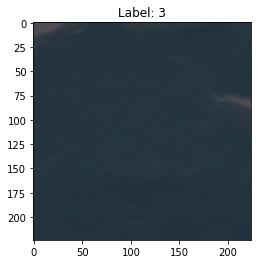

In [12]:
import matplotlib.pyplot as plt


# Accessing Data and Targets in a PyTorch DataLoader
for images, labels, names in dataloader_train_simsiam:
    img = images[0][0]
    print(img.shape)
    # img = images[0].squeeze()
    # print(img)
    label = labels[0]
    plt.title("Label: " + str(int(label)))
    plt.imshow(torch.permute(img,(1, 2, 0)))
    plt.show()
    break

In [13]:
# Create a torchvision transformation for embedding the dataset after training
# here, we resize the images to match the input size during training and apply
# a normalization of the color channel based on statistics from imagenet.
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(
    #     mean=lightly.data.collate.imagenet_normalize['mean'],
    #     std=lightly.data.collate.imagenet_normalize['std'],
    # )
])

# Create a lightly dataset for embedding.
base = torchvision.datasets.ImageFolder(root=path_to_data)
dataset_test = lightly.data.LightlyDataset.from_torch_dataset(base,
                                                              transform=test_transforms)

# Create a dataloader for embedding.
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# Create the SimSiam model

In [14]:
class SimSiam(nn.Module):
    def __init__(
        self, backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim
    ):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(
            num_ftrs, proj_hidden_dim, out_dim
        )
        self.prediction_head = SimSiamPredictionHead(
            out_dim, pred_hidden_dim, out_dim
        )

    def forward(self, x):
        # get representations
        f = self.backbone(x).flatten(start_dim=1)
        # get projections
        z = self.projection_head(f)
        # get predictions
        p = self.prediction_head(z)
        # stop gradient
        z = z.detach()
        return z, p

In [15]:
# We use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch.
resnet = torchvision.models.resnet18(weights=None) # ADDED
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

SimSiam uses a symmetric negative cosine similarity loss and does therefore not require any negative samples. We build a criterion and an optimizer.



In [16]:
# SimSiam uses a symmetric negative cosine similarity loss
criterion = lightly.loss.NegativeCosineSimilarity()

# scale the learning rate
lr = 0.05 * batch_size / 256
# use SGD with momentum and weight decay
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)

# Train SimSiam

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

avg_loss = 0.
avg_output_std = 0.
for e in range(epochs):

    for (x0, x1), _, _ in dataloader_train_simsiam:

        # move images to the gpu
        x0 = x0.to(device)
        x1 = x1.to(device)

        # run the model on both transforms of the images
        # we get projections (z0 and z1) and
        # predictions (p0 and p1) as output
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # apply the symmetric negative cosine similarity
        # and run backpropagation
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # calculate the per-dimension standard deviation of the outputs
        # we can use this later to check whether the embeddings are collapsing
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # use moving averages to track the loss and standard deviation
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # the level of collapse is large if the standard deviation of the l2
    # normalized output is much smaller than 1 / sqrt(dim)
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)
    # print intermediate results
    print(f'[Epoch {e:3d}] '
        f'Loss = {avg_loss:.2f} | '
        f'Collapse Level: {collapse_level:.2f} / 1.00')

[Epoch   0] Loss = -0.94 | Collapse Level: 0.14 / 1.00
[Epoch   1] Loss = -0.97 | Collapse Level: 0.14 / 1.00
[Epoch   2] Loss = -0.97 | Collapse Level: 0.13 / 1.00


In [18]:
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):
        # move the images to the gpu
        x = x.to(device)
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

# Scatter Plot and Nearest Neighbors

In [19]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [20]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

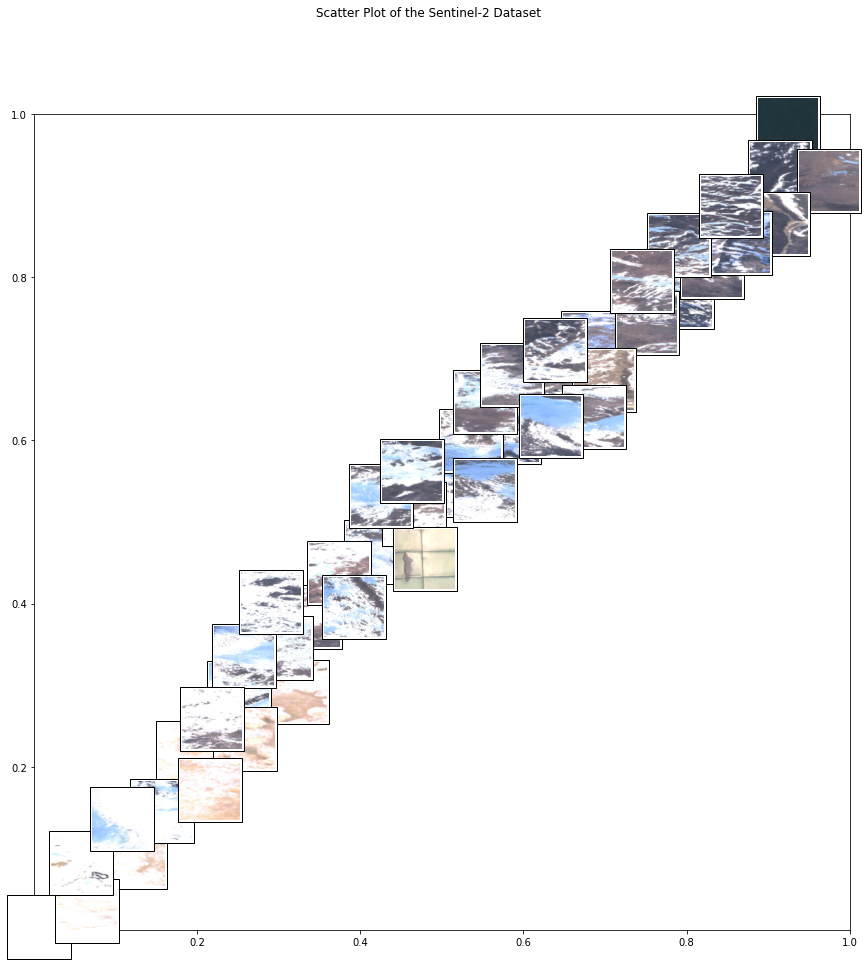

In [21]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 10.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

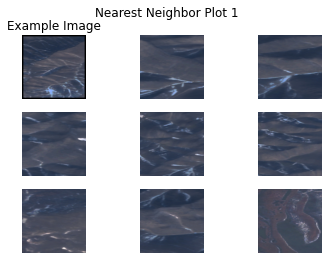

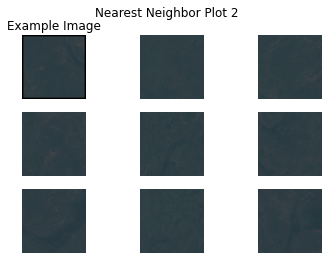

In [22]:
example_images = [
    '02_MossAndLichen_jpeg/2_MossAndLichen_90.0__4618_0.2_(+67.4397623138,+169.7815886985)_RU_Chukotskiy-Avtonomnyy-Okrug_nan_Pevek.jpg', # water 1
    '06_ForestsOpDeBr_jpeg/6_ForestsOpDeBr_80.0__4363_15.8_(+7.5760317801,+17.1542286655)_TD_Logone-Oriental_nan_Beboto.jpg', # water 2
    # 'S2B_MSIL1C_20200526T101559_N0209_R065_T32TNL/tile_00556.png', # land
    # 'S2B_MSIL1C_20200526T101559_N0209_R065_T31SGD/tile_01731.png', # clouds 1
    # 'S2B_MSIL1C_20200526T101559_N0209_R065_T32SMG/tile_00238.png', # clouds 2
]


def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)